In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic-competition-how-top-lb-got-their-score/__results__.html
/kaggle/input/titanic-competition-how-top-lb-got-their-score/submission.csv
/kaggle/input/titanic-competition-how-top-lb-got-their-score/__resultx__.html
/kaggle/input/titanic-competition-how-top-lb-got-their-score/__notebook__.ipynb
/kaggle/input/titanic-competition-how-top-lb-got-their-score/__output__.json
/kaggle/input/titanic-competition-how-top-lb-got-their-score/custom.css
/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Data Preperation 

First of all, I merge the train and test data into full data so preparation would be easy.

In [2]:
import pandas as pd 
df_train = pd.read_csv('/kaggle/input/titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')
df_full = pd.concat([df_train,df_test],axis = 0)

In [3]:
print(df_train.shape)
print(df_test.shape)
print(df_full.shape)

(891, 12)
(418, 11)
(1309, 12)


According to NA value:
* Filling the Age by doing EDA
* Filling the Embark by doing EDA
* Filling the Fare by doing EDA
* Ignore Cabin because there are a lot of data missing which is no sense to recover/imitate it


In [4]:
df_full.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

# EDA (Exploratory Data Analysis)
For missing values or creating new features that helps the model to be trained

In [5]:
df_full.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Age

In [6]:
# what is the best correlation for age:

full_cor=df_full[['Pclass','Age','SibSp','Parch','Fare']].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
full_cor=full_cor.rename(columns={'level_0':'feature1','level_1':'feature2',0:'score'})
age_corr=full_cor[full_cor['feature1'] == 'Age']
age_corr

,feature1,feature2,score
1,Age,Age,1.000000
8,Age,Pclass,0.408106
11,Age,SibSp,0.243699
15,Age,Fare,0.178740
19,Age,Parch,0.150917


In [7]:
print('Missing value for AGE as percentage: %',int(100*(df_full.isna().sum()['Age']/len(df_full))))

Missing value for AGE as percentage: % 20


In [8]:
#what if i use mean() in filling na of age:

df_full['Age'].mean()

29.881137667304014

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

print('*Here the gender distribution in each PClass*')
df_full.groupby('Pclass')['Sex'].value_counts()

*Here the gender distribution in each PClass*


Pclass  Sex   
1       male      179
        female    144
2       male      171
        female    106
3       male      493
        female    216
Name: count, dtype: int64

In [10]:
for k in range (1,4):
    for each in ('male','female'):
        value=df_full[(df_full['Pclass'] == k) & (df_full['Sex'] == each)]['Age'].mean()
        print('Mean Value of C{0} class for man has {1} age'.format(k,round(value,2)))

Mean Value of C1 class for man has 41.03 age
Mean Value of C1 class for man has 37.04 age
Mean Value of C2 class for man has 30.82 age
Mean Value of C2 class for man has 27.5 age
Mean Value of C3 class for man has 25.96 age
Mean Value of C3 class for man has 22.19 age


> We can see that each mean value in Pclass and Sex section is different. That's why,filling NA value of age with mean value of full data can deviate the age data from the correctness. So I need the missing value to be filled out by these mean values above.


In [11]:
# Fill missing Age values for Pclass 1 and Sex male
df_full.loc[(df_full['Age'].isna()) & (df_full['Pclass'] == 1) & (df_full['Sex'] == 'male'), 'Age'] = 41

# Fill missing Age values for Pclass 1 and Sex female
df_full.loc[(df_full['Age'].isna()) & (df_full['Pclass'] == 1) & (df_full['Sex'] == 'female'), 'Age'] = 37

# Fill missing Age values for Pclass 2 and Sex male
df_full.loc[(df_full['Age'].isna()) & (df_full['Pclass'] == 2) & (df_full['Sex'] == 'male'), 'Age'] = 28

# Fill missing Age values for Pclass 2 and Sex female
df_full.loc[(df_full['Age'].isna()) & (df_full['Pclass'] == 2) & (df_full['Sex'] == 'female'), 'Age'] = 37

# Fill missing Age values for Pclass 3 and Sex male
df_full.loc[(df_full['Age'].isna()) & (df_full['Pclass'] == 3) & (df_full['Sex'] == 'male'), 'Age'] = 26

# Fill missing Age values for Pclass 3 and Sex female
df_full.loc[(df_full['Age'].isna()) & (df_full['Pclass'] == 3) & (df_full['Sex'] == 'female'), 'Age'] = 22


In [12]:
age_class = []
vulnerable = []
for _, row in df_full.iterrows():
    age = row['Age']
    if age < 12:
        if age < 5:
            vulnerable.append('Very High')
        else:
            vulnerable.append('High')
        age_class.append('Child')
    elif age >12 and age <18:
        vulnerable.append('Normal')
        age_class.append('Teen')
    elif age >18 and age < 30:
        vulnerable.append('Low')
        age_class.append('Adult')
    elif age >30 and age < 60:
        if age < 50:
            vulnerable.append('Normal')
        else:
            vulnerable.append('High')
        age_class.append('Mid-Age')
    else:
        age_class.append('Elder')
        vulnerable.append('Very High')

df_full['AgeClass'] = age_class
df_full['Vulnerability'] = vulnerable


## Embarked

In [13]:
df_full['Embarked'].isna().sum()

2

In [14]:
df_full['Embarked']

0      S
1      C
2      S
3      S
4      S
      ..
413    S
414    C
415    S
416    S
417    C
Name: Embarked, Length: 1309, dtype: object

In [15]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df = df_full.copy()
df['Embarked'] = label_encoder.fit_transform(df['Embarked'])
df['Sex'] = label_encoder.fit_transform(df['Sex'])


df_cor=df[['Embarked','Pclass', 'Age','Sex','SibSp','Parch','Fare']].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
full_cor=df_cor.rename(columns={'level_0':'feature1','level_1':'feature2',0:'score'})
full_cor[full_cor['feature1'] == 'Embarked']

,feature1,feature2,score
0,Embarked,Embarked,1.000000
14,Embarked,Fare,0.235763
26,Embarked,Pclass,0.182154
35,Embarked,Sex,0.095215
39,Embarked,SibSp,0.064519
43,Embarked,Age,0.050023
46,Embarked,Parch,0.043835


In [16]:
df_full[df_full['Embarked'].isna()]['Fare']

61     80.0
829    80.0
Name: Fare, dtype: float64

In [17]:
set(df_full['Embarked'])

{'C', 'Q', 'S', nan}

In [18]:
#how much as mean is which embarked to get in:
print(df[df_full['Embarked'] == 'C']['Fare'].mean())
print(df[df_full['Embarked'] == 'Q']['Fare'].mean())
print(df[df_full['Embarked'] == 'S']['Fare'].mean())

62.33626740740739
12.409012195121951
27.418823877327494


**According to the average value, we can say that fare in the person who is not known where they got in is high as 80 euro. So we can say that they are C.**

In [19]:
df_full.loc[df_full['Embarked'].isna(),'Embarked'] = 'C'

In [20]:
df_full['Embarked'].isna().sum()

0

## Cabin

Ignore it because of lack of data

In [21]:
df_full= df_full.drop('Cabin',axis = 1)

In [22]:
df_full.shape

(1309, 13)

## Fare

In [23]:
#df is already encoded, so i am using it on behalf of df_full. Also it is very good that it is a copy of main data.
full_cor = df[['Embarked','Pclass', 'Age','Sex','SibSp','Parch','Fare']].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
full_cor[full_cor['level_0'] == 'Fare']

,level_0,level_1,0
6,Fare,Fare,1.000000
7,Fare,Pclass,0.558629
13,Fare,Embarked,0.235763
15,Fare,Parch,0.221539
22,Fare,Age,0.197878
24,Fare,Sex,0.185523
28,Fare,SibSp,0.160238


In [24]:
df_cor=df[['Embarked','Pclass']].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_cor
# since the releation btw embarked and pclass is far away, so i can pick only Pclass up in estimating FARE. 

,level_0,level_1,0
0,Embarked,Embarked,1.000000
1,Pclass,Pclass,1.000000
2,Embarked,Pclass,0.182154
3,Pclass,Embarked,0.182154


In [25]:
df_full[df_full['Fare'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,AgeClass,Vulnerability
152,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S,Elder,Very High


In [26]:
print(df_full[df_full['Embarked'] == 'S']['Fare'].mean())

27.418823877327494


In [27]:
df_full.loc[df_full['Fare'].isna(),'Fare'] = 27.42

In [28]:
df_full.isna().sum()

PassengerId        0
Survived         418
Pclass             0
Name               0
Sex                0
Age                0
SibSp              0
Parch              0
Ticket             0
Fare               0
Embarked           0
AgeClass           0
Vulnerability      0
dtype: int64

In [29]:
class_fare = df_full.groupby('Pclass')['Fare'].value_counts().reset_index()
firstC_fare = class_fare[class_fare['Pclass'] == 1]['Fare']
secondC_fare = class_fare[class_fare['Pclass'] == 2]['Fare']
thirdC_fare = class_fare[class_fare['Pclass'] == 3]['Fare']

print('First Class Max:{0}, Min:{1}, Ave:{2}'.format(max(firstC_fare),min(firstC_fare),round(firstC_fare.mean(),2)))
print('Second Class Max:{0}, Min:{1}, Ave:{2}'.format(max(secondC_fare),min(secondC_fare),round(secondC_fare.mean(),2)))
print('Third Class Max:{0}, Min:{1}, Ave:{2}'.format(max(thirdC_fare),min(thirdC_fare),round(thirdC_fare.mean(),2)))

First Class Max:512.3292, Min:0.0, Ave:77.41
Second Class Max:73.5, Min:0.0, Ave:21.95
Third Class Max:69.55, Min:0.0, Ave:13.14


In [30]:
class_fare = df_full.groupby('Pclass')['Fare'].value_counts().reset_index()
c_fare = []
fare_class = {}
for each in range(1,4):
    C_fare = class_fare[class_fare['Pclass'] == each]['Fare']
    print('Class{0}--> Max:{1}, Min:{2}, Ave:{3}'.format(each,max(C_fare),min(C_fare),round(C_fare.mean(),2)))
    fare_class[each] = C_fare
    

Class1--> Max:512.3292, Min:0.0, Ave:77.41
Class2--> Max:73.5, Min:0.0, Ave:21.95
Class3--> Max:69.55, Min:0.0, Ave:13.14


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


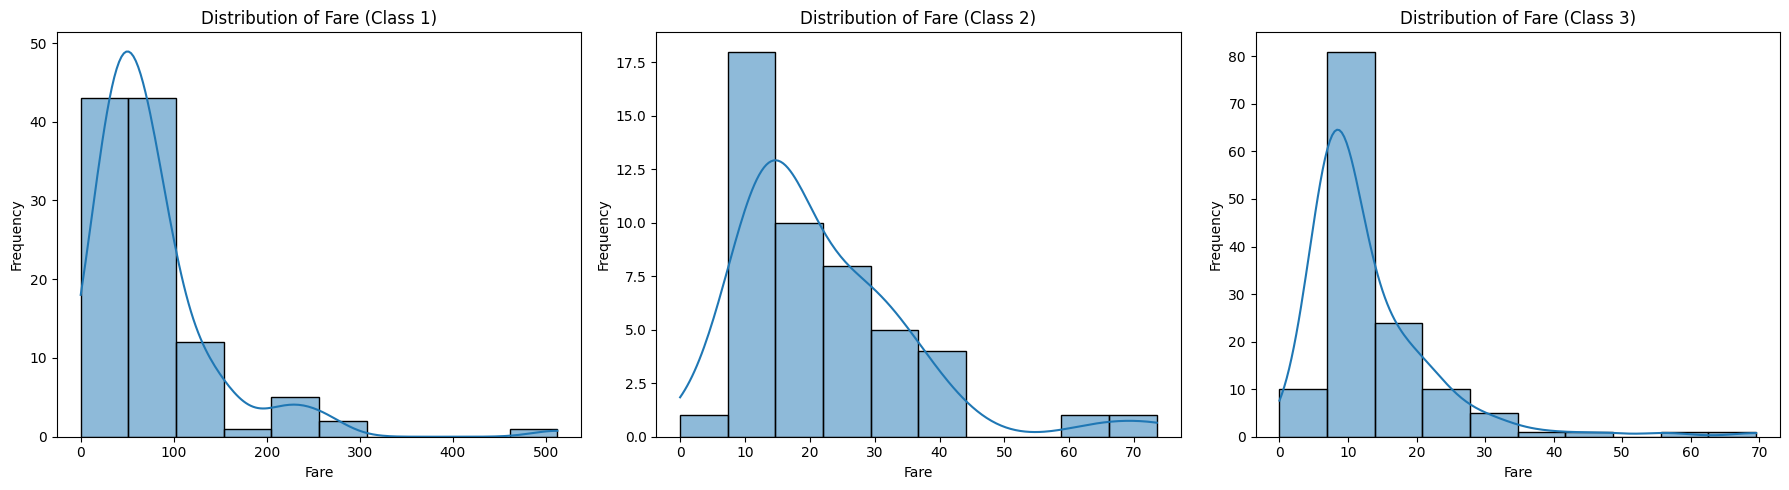

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and three subplots in a single row (1x3)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx,k in enumerate(fare_class.keys()):
    sns.histplot(fare_class[k], bins=10, kde=True, ax=axes[idx])  # Use `idx` to increment through axes
    axes[idx].set_title('Distribution of Fare (Class {})'.format(k))  # Dynamic class title
    axes[idx].set_xlabel('Fare')
    axes[idx].set_ylabel('Frequency')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()

* Pclass 1 (First Class):
 * Economy: 0 - 50
 * Standard: 50 - 150
 * Luxury: 150 - 300
 * Premium: 300 - 550+
*  Pclass 2 (Second Class):
 * Basic: 0 - 10
 * Comfort: 10 - 30
 * Select: 30 - 50+
* Pclass 3 (Third Class):
 * Budget: 0 - 10
 * Regular: 10 - 30
 * Plus: 30 - 50+

In [32]:
df_full['Fare_Class'] = ''

# For Pclass 1
df_full.loc[(df_full['Pclass'] == 1) & (df_full['Fare'] <= 50), 'Fare_Class'] = 'Economy'
df_full.loc[(df_full['Pclass'] == 1) & (df_full['Fare'] > 50) & (df_full['Fare'] <= 150), 'Fare_Class'] = 'Standard'
df_full.loc[(df_full['Pclass'] == 1) & (df_full['Fare'] > 150) & (df_full['Fare'] <= 300), 'Fare_Class'] = 'Luxury'
df_full.loc[(df_full['Pclass'] == 1) & (df_full['Fare'] > 300), 'Fare_Class'] = 'Premium'

# For Pclass 2
df_full.loc[(df_full['Pclass'] == 2) & (df_full['Fare'] <= 10), 'Fare_Class'] = 'Basic'
df_full.loc[(df_full['Pclass'] == 2) & (df_full['Fare'] > 10) & (df_full['Fare'] <= 30), 'Fare_Class'] = 'Comfort'
df_full.loc[(df_full['Pclass'] == 2) & (df_full['Fare'] > 30), 'Fare_Class'] = 'Select'

# For Pclass 3
df_full.loc[(df_full['Pclass'] == 3) & (df_full['Fare'] <= 10), 'Fare_Class'] = 'Budget'
df_full.loc[(df_full['Pclass'] == 3) & (df_full['Fare'] > 10) & (df_full['Fare'] <= 30), 'Fare_Class'] = 'Regular'
df_full.loc[(df_full['Pclass'] == 3) & (df_full['Fare'] > 30), 'Fare_Class'] = 'Plus'


In [33]:
df_full.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,AgeClass,Vulnerability,Fare_Class
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Adult,Low,Budget
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mid-Age,Normal,Standard
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Adult,Low,Budget
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mid-Age,Normal,Standard
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mid-Age,Normal,Budget


## Family

In [34]:
df_full.shape

(1309, 14)

In [35]:
fam_type = []

for _, row in df_full.iterrows():
    age = row['Age']
    sib = row['SibSp']
    par = row['Parch']
    
    if age < 18 and par > 0:
        fam_type.append('Child') 
    elif age >= 18 and par > 0 and sib == 0:
        # Adult with parent(s), no sibling or spouse
        fam_type.append('With Parent') 
    elif age >= 18 and par > 0 and sib > 0:
        # Adult with child(ren) or spouse
        fam_type.append('Parent')
    else:
        fam_type.append('with Sibling or Wife')
#family category    
df_full['FamType'] = fam_type

In [36]:
fam_size = []

for _, row in df_full.iterrows():
    sib = row['SibSp']
    par = row['Parch']
    num = sib + par
    if num == 0:
        fam_size.append('Alone')
    elif num > 0 and num < 4:
        fam_size.append('Small')
    else:
        fam_size.append('Big')

df_full['FamSize'] = fam_size

## Prefix

In [37]:
mylist = []
for each in df_full['Name']:
    parts_after_comma = each.split(',')
    before_dot = parts_after_comma[1].split('.')[0].strip()
    mylist.append(before_dot)
        
df_full['Prefix'] = mylist

df_full['Prefix'] = df_full['Prefix'].replace(['Lady', 'Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Jonkheer', 'Dona'], 'Rare')
df_full['Prefix'] = df_full['Prefix'].replace(['Countess', 'Lady', 'Sir'], 'Royal')
df_full['Prefix'] = df_full['Prefix'].replace('Mlle', 'Miss')
df_full['Prefix'] = df_full['Prefix'].replace('Ms', 'Miss')
df_full['Prefix'] = df_full['Prefix'].replace('Mme', 'Mrs')

# How the data looks like:

In [38]:
df_full.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,AgeClass,Vulnerability,Fare_Class,FamType,FamSize,Prefix
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Adult,Low,Budget,with Sibling or Wife,Small,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mid-Age,Normal,Standard,with Sibling or Wife,Small,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Adult,Low,Budget,with Sibling or Wife,Alone,Miss


# Data Split and Encoding

In [39]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

df_full['Sex'] = label_encoder.fit_transform(df_full['Sex'])
df_full['Embarked'] = label_encoder.fit_transform(df_full['Embarked'])
df_full['FamType'] = label_encoder.fit_transform(df_full['FamType'])
df_full['FamSize'] = label_encoder.fit_transform(df_full['FamSize'])
df_full['Prefix'] = label_encoder.fit_transform(df_full['Prefix'])
df_full['AgeClass'] = label_encoder.fit_transform(df_full['AgeClass'])
df_full['Vulnerability'] = label_encoder.fit_transform(df_full['Vulnerability'])
df_full['Fare_Class'] = label_encoder.fit_transform(df_full['Fare_Class'])

In [40]:
df_full.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,AgeClass,Vulnerability,Fare_Class,FamType,FamSize,Prefix
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,2,0,1,1,3,2,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,0,3,2,9,3,2,3
2,3,1.0,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,2,0,1,1,3,0,1


In [41]:
drop_feature = ['PassengerId','Name','Ticket']
df_full= df_full.drop(drop_feature,axis = 1)

In [42]:
drop_feature = ['Age']
df_full= df_full.drop(drop_feature,axis = 1)

In [43]:
df_full.head(3)

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,AgeClass,Vulnerability,Fare_Class,FamType,FamSize,Prefix
0,0.0,3,1,1,0,7.2500,2,0,1,1,3,2,2
1,1.0,1,0,1,0,71.2833,0,3,2,9,3,2,3
2,1.0,3,0,0,0,7.9250,2,0,1,1,3,0,1


In [44]:
full_cor = df_full[['Survived','Pclass','Sex','SibSp','Parch','Fare','FamType','FamSize','AgeClass','Vulnerability']].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
full_cor[full_cor['level_0'] == 'Survived']

,level_0,level_1,0
0,Survived,Survived,1.000000
15,Survived,Sex,0.543351
31,Survived,Pclass,0.338481
34,Survived,Fare,0.257307
37,Survived,FamSize,0.249714
59,Survived,FamType,0.137674
64,Survived,AgeClass,0.101990
71,Survived,Vulnerability,0.085744
73,Survived,Parch,0.081629
90,Survived,SibSp,0.035322


In [45]:
full_cor = df_full[['Survived','Pclass','Sex','SibSp','Parch','Fare','FamType','FamSize','AgeClass','Vulnerability','Fare_Class']].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
full_cor[full_cor['level_0'] == 'Survived']

,level_0,level_1,0
0,Survived,Survived,1.000000
17,Survived,Sex,0.543351
40,Survived,Pclass,0.338481
48,Survived,Fare_Class,0.266302
49,Survived,Fare,0.257307
52,Survived,FamSize,0.249714
78,Survived,FamType,0.137674
83,Survived,AgeClass,0.101990
90,Survived,Vulnerability,0.085744
91,Survived,Parch,0.081629


*Seeing that it's nice that fare_class is more effective than fare.*

In [46]:
df_train = df_full.iloc[:890]
df_test = df_full.iloc[891:]

In [47]:
y = df_train['Survived']
df_train = df_train.drop('Survived',axis =  1)

In [48]:
df_train.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked,AgeClass,Vulnerability,Fare_Class,FamType,FamSize,Prefix
0,3,1,1,0,7.2500,2,0,1,1,3,2,2
1,1,0,1,0,71.2833,0,3,2,9,3,2,3
2,3,0,0,0,7.9250,2,0,1,1,3,0,1
3,1,0,1,0,53.1000,2,3,2,9,3,2,3
4,3,1,0,0,8.0500,2,3,2,1,3,0,2


In [49]:
df_test = df_test.drop('Survived',axis =  1)

In [50]:
df_test.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked,AgeClass,Vulnerability,Fare_Class,FamType,FamSize,Prefix
0,3,1,0,0,7.8292,1,3,2,1,3,0,2
1,3,0,1,0,7.0000,2,3,2,1,3,2,3
2,2,1,0,0,9.6875,1,2,3,0,3,0,2
3,3,1,0,0,8.6625,2,0,1,1,3,0,2
4,3,0,1,1,12.2875,2,0,1,7,1,2,3


## Model Training

In [51]:
''' A little bit overfitting here 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

cat_list = ['Pclass','Sex','SibSp','Parch','Embarked','Prefix','FamType','FamSize','AgeClass','Vulnerability','Fare_Class']
#num_list = ['Fare']

preprocessor = ColumnTransformer(
    transformers=[
        #('num', numerical_transformer, num_list)
        ('cat', categorical_transformer, cat_list)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier',  SVC())])


X_train, X_test, y_train, y_test = train_test_split(df_train, y, train_size=0.8, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy for {}".format(accuracy))
'''

' A little bit overfitting here \n\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.preprocessing import StandardScaler, OneHotEncoder\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.compose import ColumnTransformer\nfrom sklearn.metrics import accuracy_score\nfrom sklearn.ensemble import GradientBoostingClassifier\nfrom sklearn.svm import SVC\nfrom sklearn.model_selection import train_test_split\n\nnumerical_transformer = StandardScaler()\ncategorical_transformer = OneHotEncoder(handle_unknown=\'ignore\')\n\ncat_list = [\'Pclass\',\'Sex\',\'SibSp\',\'Parch\',\'Embarked\',\'Prefix\',\'FamType\',\'FamSize\',\'AgeClass\',\'Vulnerability\',\'Fare_Class\']\n#num_list = [\'Fare\']\n\npreprocessor = ColumnTransformer(\n    transformers=[\n        #(\'num\', numerical_transformer, num_list)\n        (\'cat\', categorical_transformer, cat_list)\n    ])\n\nmodel = Pipeline(steps=[\n    (\'preprocessor\', preprocessor),\n    (\'classifier\',  SVC())])\n\n\nX_train, X_test,

In [52]:
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

cat_list = ['Pclass','Sex','SibSp','Parch','Embarked','Prefix','FamType','FamSize','AgeClass','Vulnerability','Fare_Class']
#num_list = ['Fare']

preprocessor = ColumnTransformer(
    transformers=[
        #('num', numerical_transformer, num_list),
        ('cat', categorical_transformer, cat_list)
    ])

feature=cat_list#+num_list

# Define your pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        random_state=100,
        max_features=5,
        n_iter_no_change=10,  # Early stopping after 10 rounds of no improvement
        validation_fraction=0.1  # Use 20% of training data as validation set
    ))
])


errors = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(df_train):
    X_train, X_test = df_train.iloc[train_index], df_train.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    y_pred =[int(each) for each in y_pred]
    accuracy = accuracy_score(y_pred, y_test)
    print("Accuracy for {}".format(accuracy))



Accuracy for 0.848314606741573
Accuracy for 0.8202247191011236
Accuracy for 0.848314606741573
Accuracy for 0.797752808988764
Accuracy for 0.8202247191011236


In [53]:
yped = model.predict(df_test)

In [54]:
p_id = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')['PassengerId']

In [55]:
yped =[int(each) for each in yped]

In [56]:
mycsv = {
    'PassengerId' : p_id,
    'Survived' : yped
}

mydata = pd.DataFrame(mycsv) 
mydata.to_csv('/kaggle/working/myoutput.csv', index=False)

In [57]:
full_of_correct = pd.read_csv('/kaggle/input/titanic-competition-how-top-lb-got-their-score/submission.csv')['Survived']

In [58]:
accuracy = accuracy_score(yped, full_of_correct)
print("Accuracy for {}".format(accuracy))

Accuracy for 0.7870813397129187
